In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

shipsnet_json_path = 'ships_in_satellite_imagery/shipsnet.json'
shipsnet_png_dirpath = 'ships_in_satellite_imagery/shipsnet/shipsnet/'

In [2]:
'''
Load the shipsnet data in json into pandas dataframe.
Args:
    file_path : full path of the .JSON file
Return:
    pandas df with the following columns:
    'data', 'labels', 'locations' [longitude, latitude], 'scene_ids'
    The 'data' column shape will be M x 19200, M = number of RGB img chips (80x80x3)
    Structure of 19200 pixel values = [6400 R, 6400 G, 6400 B]
'''
def load_shipsnet_json(file_path):
    with open(file_path) as json_file:
        ship_data_json = json.load(json_file)
    shipsnet_df = pd.DataFrame(ship_data_json)
    return shipsnet_df

In [3]:
'''
Load data from JSON file.
'''
shipsnet_df = load_shipsnet_json(shipsnet_json_path)
shipsnet_df.head()

data  labels  \
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1   
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1   
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1   
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1   
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1   

                                   locations             scene_ids  
0    [-118.2254694333423, 33.73803725920789]  20180708_180909_0f47  
1    [-122.33222866289329, 37.7491755586813]  20170705_180816_103e  
2  [-118.14283073363218, 33.736016066914175]  20180712_211331_0f06  
3   [-122.34784341495181, 37.76648707436548]  20170609_180756_103a  
4   [-122.34852408322172, 37.75878462398653]  20170515_180653_1007

In [4]:
'''
Transform data to chips RGB in 8-bit np array.
Output shape: (num_smples, num_rows, num_cols, num_channels)
For data in shipsnet.json:
num_samples = 4000
num_rows = 80
num_cols = 80
num_channles = 3 (RGB)
This is also the data shape supported by conv2D in keras.
'''
def get_X_chips_rgb(shipsnet_df, data_col='data', channels=3, rows=80, cols=80):
    num_samples = len(shipsnet_df[data_col])
    len_data    = len(shipsnet_df[data_col][0])     # len_data = 19200 for 80x80 RGB chips 
    assert len_data == channels * rows * cols
    X = np.zeros((num_samples, len_data), dtype=np.uint8)
    for idx in range(num_samples):
        X[idx,:] = np.array(shipsnet_df[data_col][idx]).astype(dtype=np.uint8)
    X_rgb_chips = X.reshape(-1, channels, rows, cols)
    X_chips_rgb = X_rgb_chips.transpose([0, 2, 3, 1])
    assert (X_chips_rgb[0][0][0] == np.array([shipsnet_df.data[0][0], shipsnet_df.data[0][6400], shipsnet_df.data[0][12800]])).all(), 'Data reshaping ERROR'
    return X_chips_rgb

In [5]:
'''
Separate the chips, but keep the RGB values for each pixel (line,sample) together.
Output shape = (num_row, num_col, num_channel)
'''
X_chips_rgb = get_X_chips_rgb(shipsnet_df)
print(X_chips_rgb.shape)

(4000, 80, 80, 3)


In [6]:
'''
Get the sample class labels:
    0 : no_ship
    1 : ship
'''
y = shipsnet_df['labels']
y.value_counts()

labels
0    3000
1    1000
Name: count, dtype: int64

In [7]:
'''
Split the no_ship class into 3 sub-classes: 
    0: land
    1: partial_ship
    2: hard
The ship class will receive a new class label 3.
The new labeling will help us to understand the source of prediction errors.
'''
def split_no_ship_label(shipsnet_df):
    split_y = shipsnet_df['labels'].copy()
    split_y.rename('4-class labels')
    ship_indexes = shipsnet_df.index[shipsnet_df['labels'] == 1]
    split_y[ship_indexes] = 3
    no_ship_indexes = shipsnet_df.index[shipsnet_df['labels'] == 0]
    split_y[no_ship_indexes[1000:2000]] = 1   # partial_ship
    split_y[no_ship_indexes[2000:3000]] = 2   # hard samples (previously misclassified by some ML models)
    split_y_labels = split_y.replace({0: 'land', 1: 'partial_ship', 2: 'hard', 3: 'ship'})
    return split_y, split_y_labels

In [8]:
split_y, split_y_labels = split_no_ship_label(shipsnet_df)
print(split_y.value_counts())
print(split_y_labels.value_counts())
# print(split_y)
# print(split_y_labels)

labels
3    1000
0    1000
1    1000
2    1000
Name: count, dtype: int64
labels
ship            1000
land            1000
partial_ship    1000
hard            1000
Name: count, dtype: int64


In [9]:
# Fungsi Kernel RBF
def rbf_kernel(x1, x2, gamma=0.05):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

In [10]:
# SVM Binary Classifier Manual
class ManualSVM:
    def __init__(self, C=1.0, kernel=rbf_kernel, max_iter=1000, tol=1e-3, gamma=0.05):
        self.C = C
        self.kernel = kernel
        self.max_iter = max_iter
        self.tol = tol
        self.gamma = gamma

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples)
        self.b = 0
        self.X = X
        self.y = y
        self.K = np.array([[self.kernel(x1, x2, self.gamma) for x2 in X] for x1 in X])

        for _ in range(self.max_iter):
            alpha_prev = np.copy(self.alpha)
            for i in range(n_samples):
                # Hitung margin
                margin = (self.alpha * self.y) @ self.K[i] + self.b
                Ei = margin - self.y[i]
                if (self.y[i] * Ei < -self.tol and self.alpha[i] < self.C) or (self.y[i] * Ei > self.tol and self.alpha[i] > 0):
                    j = np.random.randint(0, n_samples)
                    if i == j: continue
                    Ej = (self.alpha * self.y) @ self.K[j] + self.b - self.y[j]
                    
                    # Hitung batas L dan H
                    if self.y[i] != self.y[j]:
                        L = max(0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0, self.alpha[j] + self.alpha[i] - self.C)
                        H = min(self.C, self.alpha[j] + self.alpha[i])
                    if L == H: continue

                    # Update alpha[j]
                    eta = 2 * self.K[i, j] - self.K[i, i] - self.K[j, j]
                    if eta >= 0: continue
                    alpha_j_new = self.alpha[j] - self.y[j] * (Ei - Ej) / eta
                    alpha_j_new = np.clip(alpha_j_new, L, H)
                    if abs(alpha_j_new - self.alpha[j]) < self.tol: continue

                    # Update alpha[i]
                    alpha_i_new = self.alpha[i] + self.y[i] * self.y[j] * (self.alpha[j] - alpha_j_new)
                    
                    # Update b
                    b1 = self.b - Ei - self.y[i] * (alpha_i_new - self.alpha[i]) * self.K[i, i] - self.y[j] * (alpha_j_new - self.alpha[j]) * self.K[i, j]
                    b2 = self.b - Ej - self.y[i] * (alpha_i_new - self.alpha[i]) * self.K[i, j] - self.y[j] * (alpha_j_new - self.alpha[j]) * self.K[j, j]
                    self.b = (b1 + b2) / 2 if 0 < alpha_i_new < self.C and 0 < alpha_j_new < self.C else b1 if 0 < alpha_i_new < self.C else b2

                    self.alpha[i] = alpha_i_new
                    self.alpha[j] = alpha_j_new

            # Konvergensi
            diff = np.linalg.norm(self.alpha - alpha_prev)
            if diff < self.tol:
                break

        # Support Vectors
        self.support_vectors_ = np.where((self.alpha > 0) & (self.alpha < self.C))[0]

    def predict(self, X):
        y_pred = []
        for x in X:
            pred = sum(self.alpha[i] * self.y[i] * self.kernel(self.X[i], x, self.gamma) for i in range(len(self.alpha))) + self.b
            y_pred.append(np.sign(pred))
        return np.array(y_pred)

In [11]:
# Multiclass SVM One-vs-Rest
class MulticlassSVM:
    def __init__(self, C=1.0, kernel=rbf_kernel, max_iter=1000, tol=1e-3, gamma=0.05):
        self.C = C
        self.kernel = kernel
        self.max_iter = max_iter
        self.tol = tol
        self.gamma = gamma
        self.models = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            y_binary = np.where(y == cls, 1, -1)
            model = ManualSVM(C=self.C, kernel=self.kernel, max_iter=self.max_iter, tol=self.tol, gamma=self.gamma)
            model.fit(X, y_binary)
            self.models[cls] = model

    def predict(self, X):
        # Menghitung skor margin untuk semua model
        scores = {cls: np.array([
            sum(self.models[cls].alpha[i] * self.models[cls].y[i] * self.models[cls].kernel(self.models[cls].X[i], x, self.models[cls].gamma) 
                for i in range(len(self.models[cls].alpha))) + self.models[cls].b
            for x in X
        ]) for cls in self.classes}

        # Pilih kelas dengan margin tertinggi
        y_pred = np.array([max(scores, key=lambda cls: scores[cls][i]) for i in range(X.shape[0])])
        return y_pred


In [12]:
# Mengambil 500 data random dari seluruh class
def select_random_samples(X, y, num_samples=500, random_state=None):
    np.random.seed(random_state)
    indices = np.random.choice(len(y), num_samples, replace=False)
    return X[indices], y[indices]

In [13]:
# Proses utama
num_samples = 500  
scaler = StandardScaler()
num_iterations = 5  
classification_reports = []  
confusion_matrices = []  

for i in range(num_iterations):
    print(f"Iteration {i+1}/{num_iterations}")
    # Step 1: Mengambil sample random
    X_random, y_random = select_random_samples(X_chips_rgb, split_y_labels, num_samples=num_samples, random_state=11+i)
    print("Distribusi Data Sample setiap Label:")
    print(y_random.value_counts())
    print()
    
    # Step 2: Membagi data menjadi train (80%) dan test (20%)
    X_train, X_test, y_train, y_test = train_test_split(
        X_random.reshape(-1, 80 * 80 * 3),  # Flatten data
        y_random,
        test_size=0.2,
        random_state=42,
        stratify=y_random
    )

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("Train set label distribution:")
    print(pd.Series(y_train).value_counts())
    print()
    print("Test set label distribution:")
    print(pd.Series(y_test).value_counts())
    print()

    # Step 3: Training SVM
    svm_model = MulticlassSVM(C=1.0, max_iter=1000, gamma=0.0001)
    svm_model.fit(X_train_scaled, y_train)
    
    # Step 4: Prediksi
    y_pred = svm_model.predict(X_test_scaled)
    
    # Step 5: Simpan hasil classification report dan confusion matrix
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

Iteration 1/5
Distribusi Data Sample setiap Label:
labels
land            132
ship            125
hard            122
partial_ship    121
Name: count, dtype: int64

Train set label distribution:
labels
land            106
ship            100
partial_ship     97
hard             97
Name: count, dtype: int64

Test set label distribution:
labels
land            26
ship            25
hard            25
partial_ship    24
Name: count, dtype: int64

Iteration 2/5
Distribusi Data Sample setiap Label:
labels
partial_ship    132
ship            126
hard            124
land            118
Name: count, dtype: int64

Train set label distribution:
labels
partial_ship    106
ship            101
hard             99
land             94
Name: count, dtype: int64

Test set label distribution:
labels
partial_ship    26
ship            25
hard            25
land            24
Name: count, dtype: int64

Iteration 3/5
Distribusi Data Sample setiap Label:
labels
ship            142
land            127
partia

In [14]:
# print(X_train)
# print()
# print(y_train)
# print()
# print(y_pred)
# print()
# print(X_test)
# print()
# print(y_test)

In [15]:
# Fungsi untuk menghitung rata-rata classification report
def calculate_average_report(reports):
    # Dictionary untuk akumulasi hasil
    avg_report = defaultdict(lambda: defaultdict(float))
    for report in reports:
        for label, metrics in report.items():
            if isinstance(metrics, dict):  # Abaikan key seperti 'accuracy'
                for metric, value in metrics.items():
                    avg_report[label][metric] += value
    # Hitung rata-rata
    for label, metrics in avg_report.items():
        for metric in metrics:
            avg_report[label][metric] /= len(reports)
    return avg_report

In [16]:
# Hitung rata-rata classification report
average_report = calculate_average_report(classification_reports)
average_confusion_matrix = np.mean(confusion_matrices, axis=0)

In [17]:
# Tampilkan hasil rata-rata dan confusion matrix
print("\nAverage Classification Report:")
print(pd.DataFrame(average_report).transpose())
print()
print("\nAverage Confusion Matrix:")
print(average_confusion_matrix)


Average Classification Report:
              precision    recall  f1-score  support
hard           0.733801  0.771246  0.749702     24.4
land           0.758481  0.718949  0.733183     25.0
partial_ship   0.689942  0.627508  0.649472     25.0
ship           0.850978  0.896543  0.870875     25.6
macro avg      0.758301  0.753562  0.750808    100.0
weighted avg   0.758647  0.756000  0.752305    100.0


Average Confusion Matrix:
[[18.8  0.8  1.6  3.2]
 [ 1.4 18.   5.2  0.4]
 [ 3.4  5.2 15.8  0.6]
 [ 2.2  0.   0.4 23. ]]


In [18]:
def plot_predictions_for_label(X, y_true, y_pred, label, num_display, grid=(4, 5)):
    """
    Plot predictions for a specific label.

    Args:
        X: np.array, image data (num_samples, height, width, channels).
        y_true: np.array or list, true labels.
        y_pred: np.array or list, predicted labels.
        label: str, specific label to display (e.g., 'land', 'hard', 'ship', 'partial_ship').
        num_display: int, number of images to display for the label.
        grid: tuple, grid dimensions (default: 2x3).
    """
    np.random.seed(42)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Filter indices for the specified label
    label_indices = np.where(y_true == label)[0]
    
    # If no data matches the label, skip plotting
    if len(label_indices) == 0:
        print(f"No samples found for label '{label}'.")
        return
    
    # Randomly select images to display
    selected_indices = np.random.choice(label_indices, min(num_display, len(label_indices)), replace=False)
    
    # Plotting
    fig, axes = plt.subplots(grid[0], grid[1], figsize=(18, 10))
    for i, idx in enumerate(selected_indices):
        ax = axes[i // grid[1], i % grid[1]]
        ax.imshow(X[idx].reshape(80, 80, 3))
        ax.axis('off')
        ax.set_title(f"True: {y_true[idx]}, Pred: {y_pred[idx]}")

    plt.tight_layout()
    plt.suptitle(f"Label: {label}", fontsize=16, y=1.02)
    plt.show()


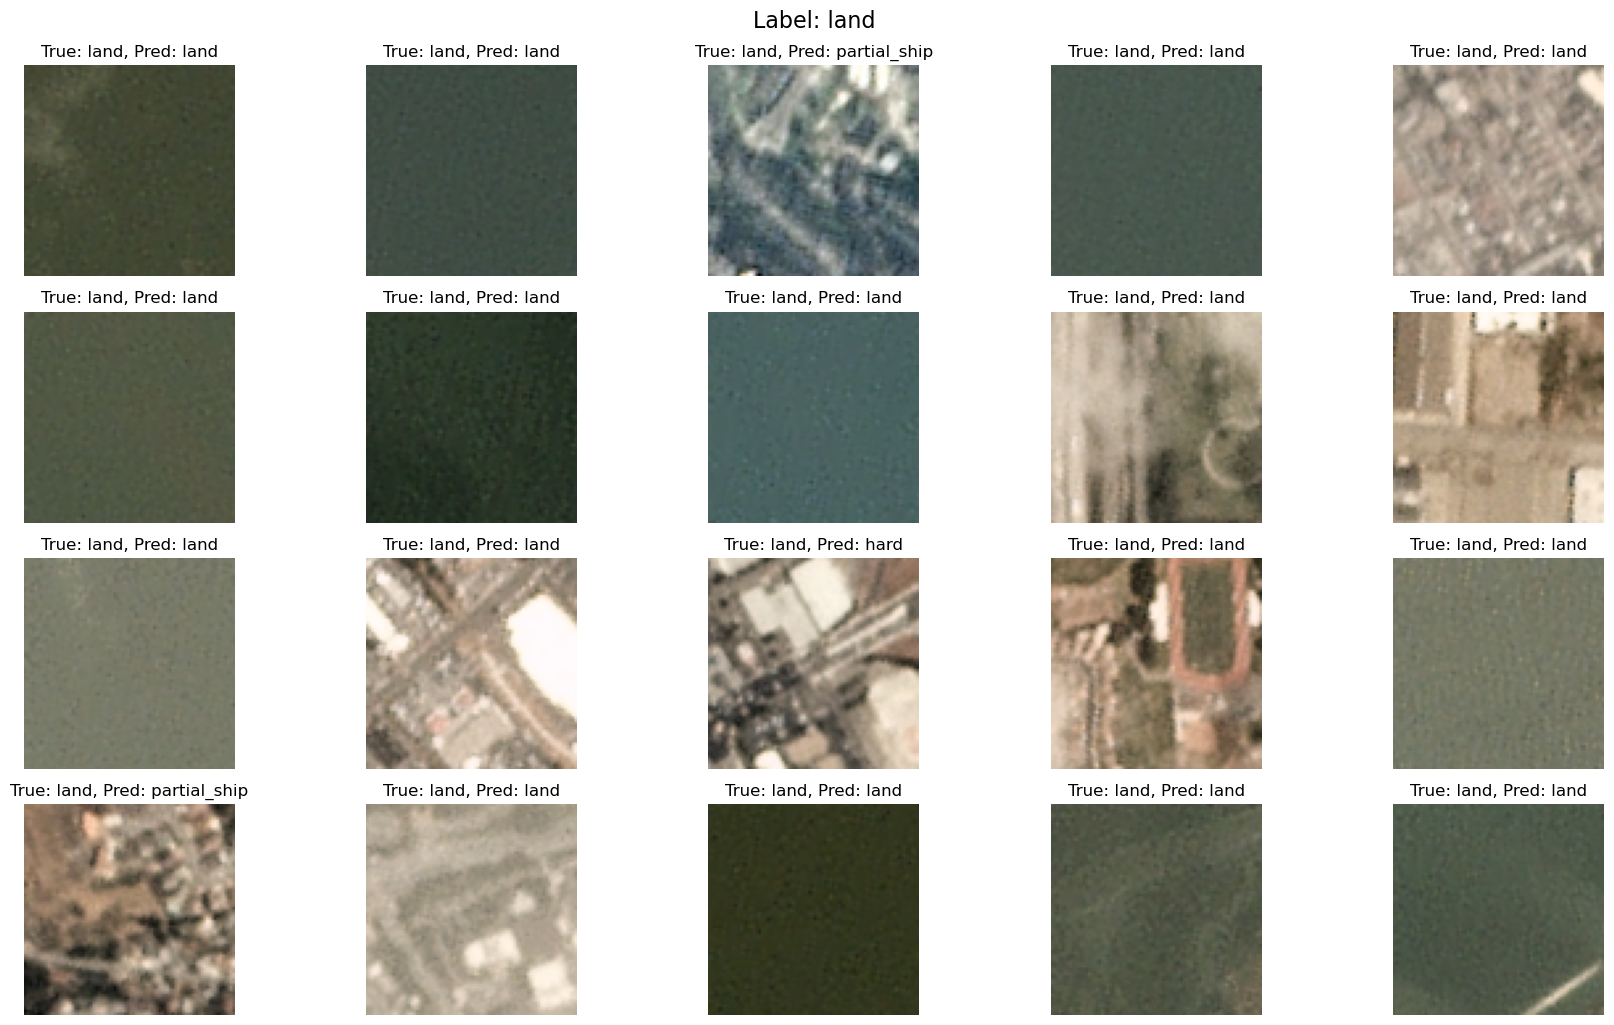

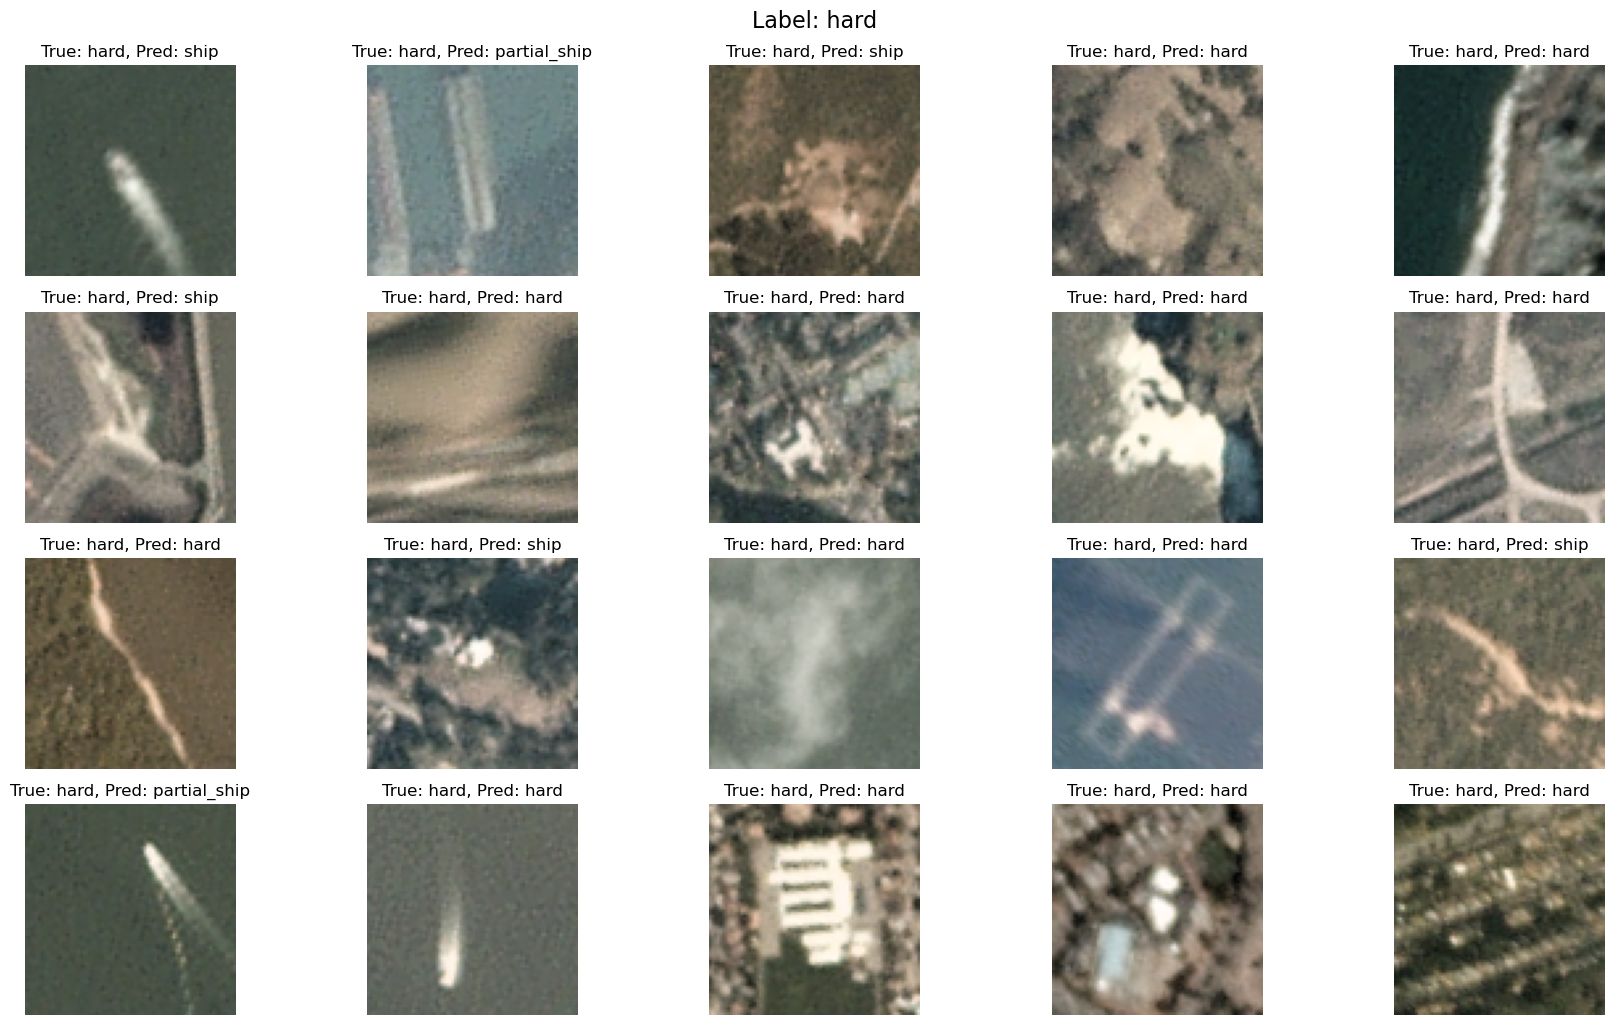

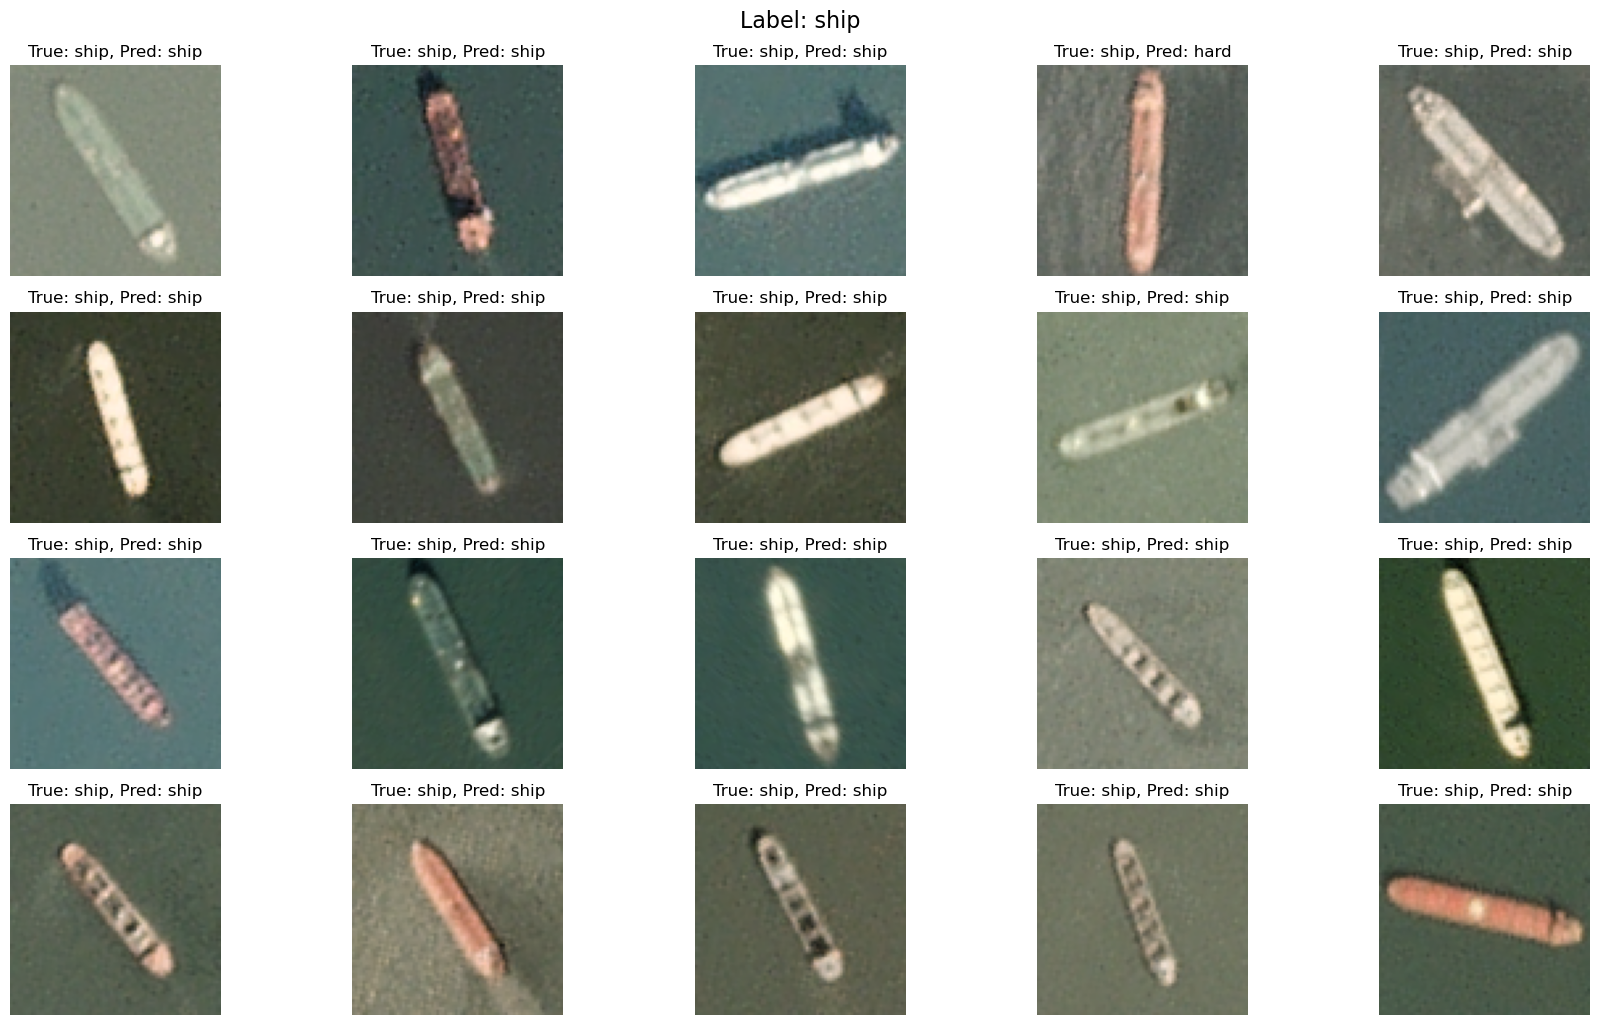

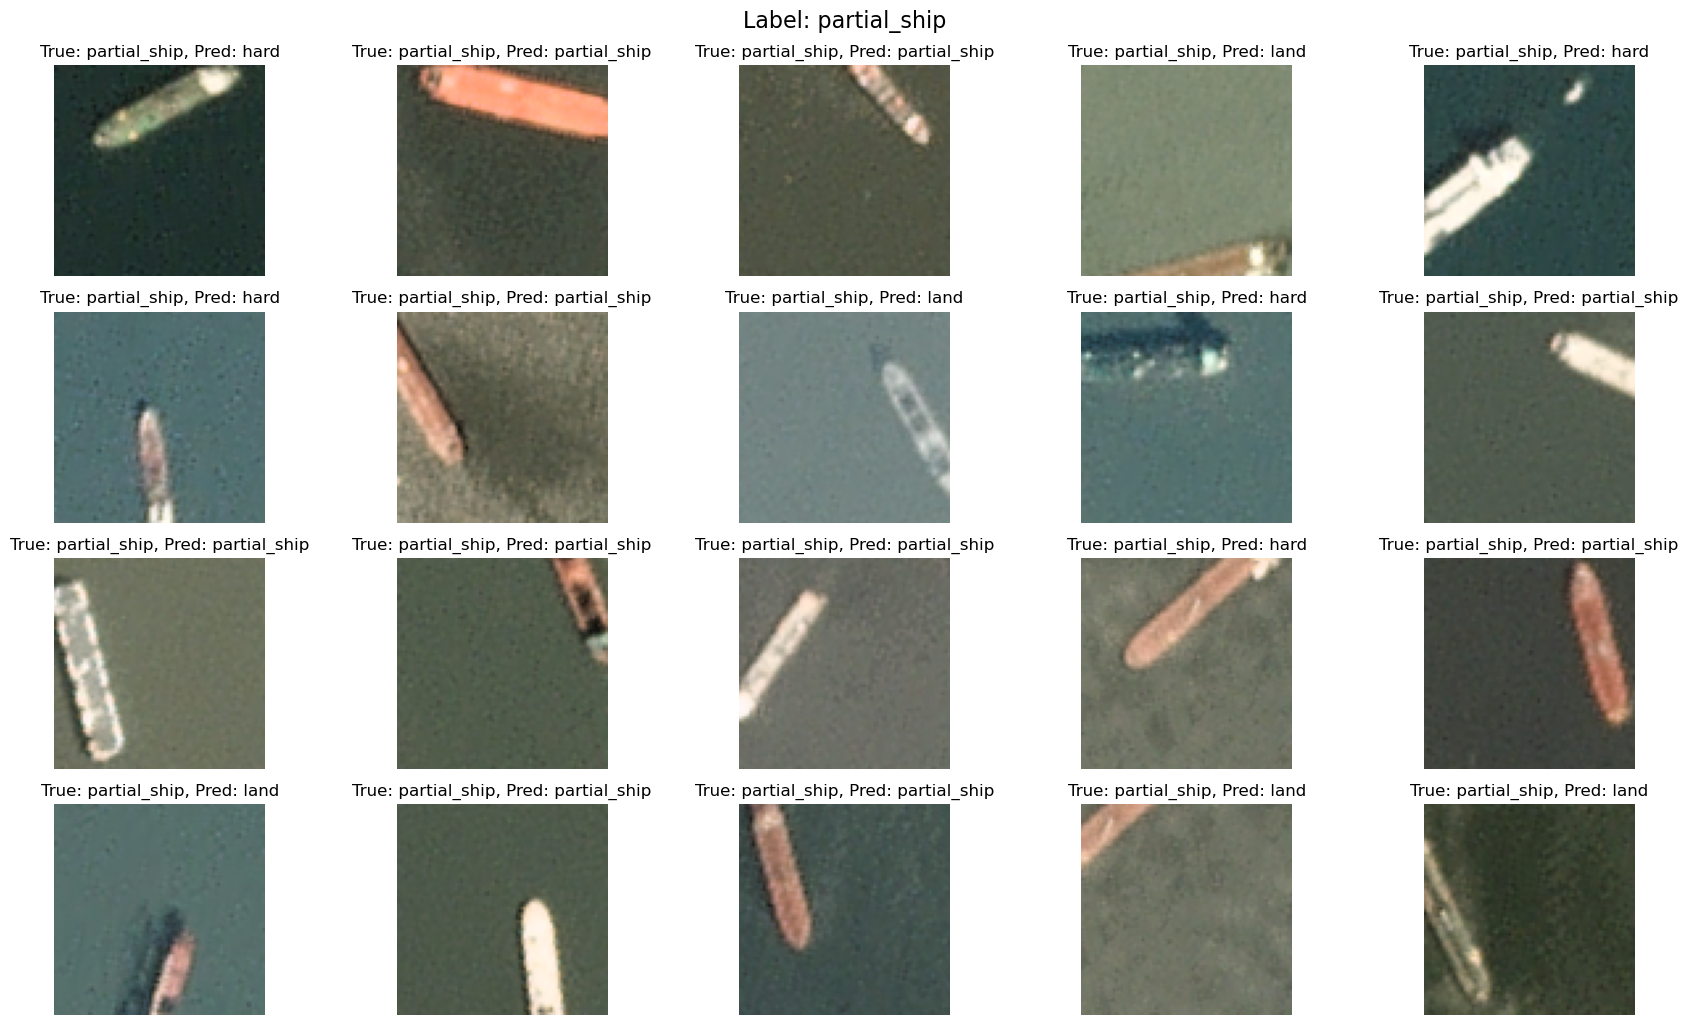

In [21]:
labels = ['land', 'hard', 'ship', 'partial_ship']

for label in labels:
    plot_predictions_for_label(
        X_test.reshape(-1, 80, 80, 3), 
        y_test, 
        y_pred, 
        label=label, 
        num_display=20,
        grid=(4, 5),     
    )
